In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


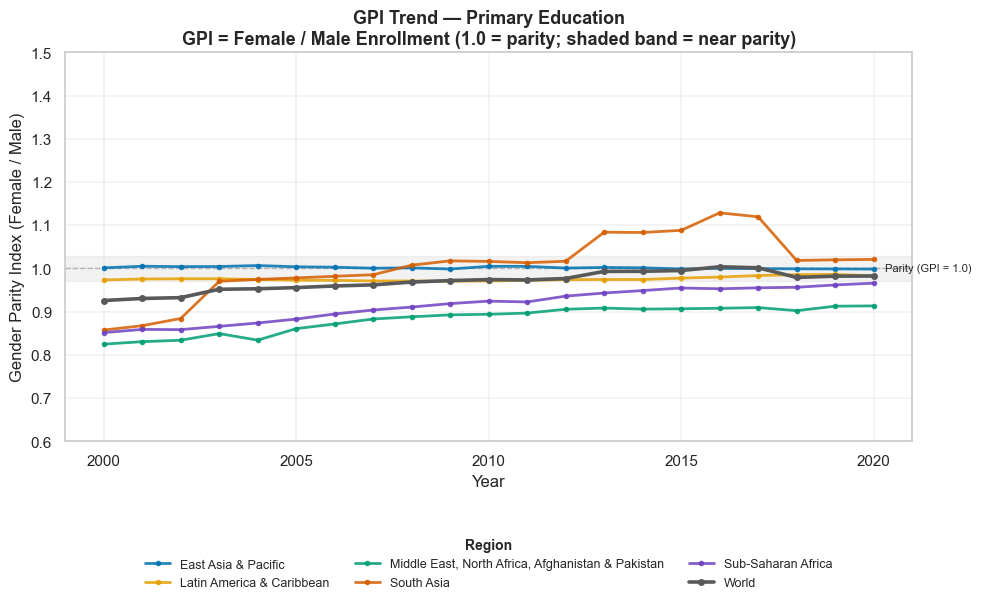

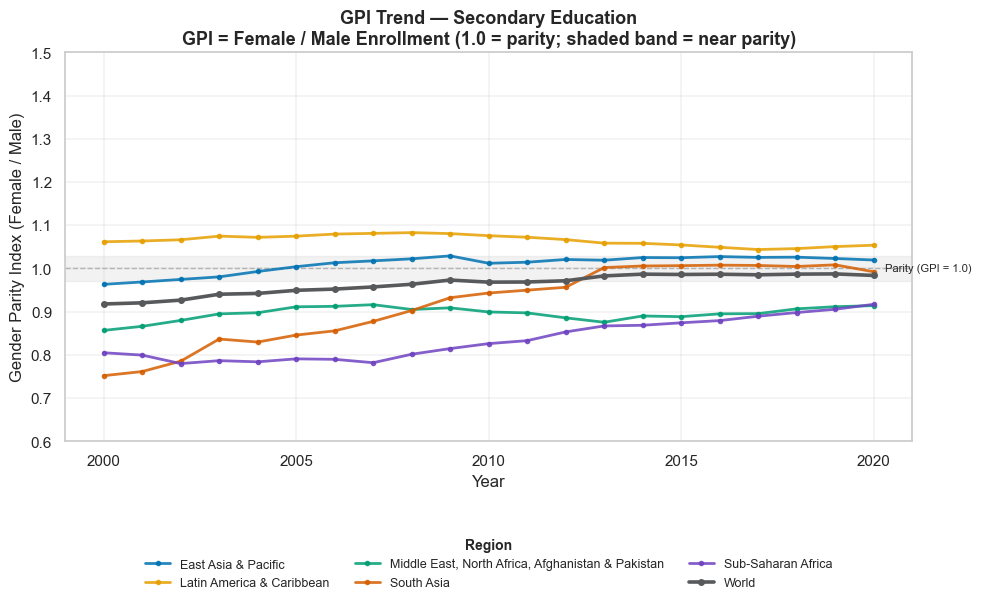

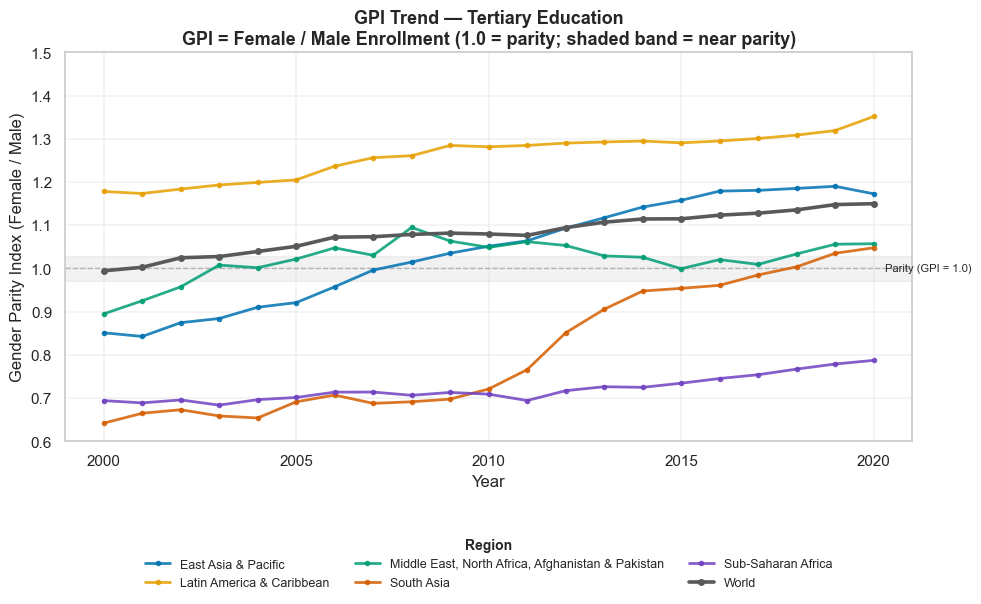

In [ ]:
df = pd.read_csv("../data/wdi_edu_filtered.csv")

df["Country"] = df["Country"].astype(str).str.strip()

gender_df = df[df["series"].str.contains("_male|_female", case=False, na=False)].copy()

year_cols = [c for c in gender_df.columns if c.startswith("YR")]
long_df = gender_df.melt(
    id_vars=["Country", "series"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Rate"
)

long_df["Year"] = long_df["Year"].str.replace("YR", "", regex=False).astype(int)
long_df[["Level", "Gender"]] = long_df["series"].str.split(pat="_", n=1, expand=True)

pivot_df = long_df.pivot_table(
    index=["Country", "Level", "Year"],
    columns="Gender",
    values="Rate"
).reset_index()

pivot_df["GPI"] = pivot_df["female"] / pivot_df["male"]
pivot_df = pivot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["GPI"])

pivot_df["Country"] = pivot_df["Country"].astype(str).str.strip()


regions = [
    "East Asia & Pacific",
    "Latin America & Caribbean",
    "Middle East, North Africa, Afghanistan & Pakistan",
    "South Asia",
    "Sub-Saharan Africa",
    "World"
]

plot_df = pivot_df[pivot_df["Country"].isin(regions)].copy()

region_colors = {
    "East Asia & Pacific": "#0072B2",      
    "Latin America & Caribbean": "#E69F00", 
    "Middle East, North Africa, Afghanistan & Pakistan": "#009E73",  # green
    "South Asia": "#D55E00",                
    "Sub-Saharan Africa": "#6F42C1",       
    "World": "#58595B"                      
}


sns.set_theme(style="whitegrid")
levels = ["primary", "secondary", "tertiary"]

for level in levels:
    fig, ax = plt.subplots(figsize=(10, 6))

    subset = plot_df[plot_df["Level"] == level]

    for region in regions:
        data = subset[subset["Country"] == region].sort_values("Year")
        if data.empty:
            continue

        line_color = region_colors.get(region, "gray")

        if region == "World":
            lw = 2.6
            alpha = 1.0
            z = 3
            markersize = 4
        else:
            lw = 2.0
            alpha = 0.85
            z = 2
            markersize = 3

        ax.plot(
            data["Year"], data["GPI"],
            marker="o",
            markersize=markersize,
            linewidth=lw,
            label=region,
            color=line_color,
            alpha=alpha,
            zorder=z
        )

    if not subset.empty:
        ax.axhspan(0.97, 1.03, color="#CFCFCF", alpha=0.25, zorder=1)
        ax.axhline(1, color="#B3B3B3", linestyle="--", linewidth=1, zorder=1)

        min_year = subset["Year"].min()
        max_year = subset["Year"].max()
        step = 5 if (max_year - min_year) >= 5 else 1
        ax.set_xticks(np.arange(min_year, max_year + 1, step))

        ax.text(
            max_year + 0.3, 1.0,
            "Parity (GPI = 1.0)",
            fontsize=8,
            va="center"
        )

    ax.set_title(
        f"GPI Trend — {level.capitalize()} Education\n"
        "GPI = Female / Male Enrollment (1.0 = parity; shaded band = near parity)",
        fontsize=13,
        weight="bold"
    )
    ax.set_ylabel("Gender Parity Index (Female / Male)", fontsize=12)
    ax.set_xlabel("Year", fontsize=12)

    ax.set_ylim(0.6, 1.5)

    ax.grid(True, linewidth=0.3)

    legend = ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=3,
        frameon=False,
        fontsize=9,
        title="Region"
    )
    if legend.get_title() is not None:
        legend.get_title().set_fontsize(10)
        legend.get_title().set_weight("bold")

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    
    
    
    # plt.savefig(f"gpi_trend_{level}.png", dpi=300, bbox_inches="tight")

    plt.show()
